In [1]:
# Boolean aliases ----
T = True
F = False
# Standard libs ----
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
# Personal libs ---- 
from networks.toy import TOY
from networks.MAC.mac57 import MAC57
from modules.hierarmerge import Hierarchy
from plotting_modules.plotting_H import Plot_H
from plotting_modules.plotting_N import Plot_N
from modules.hierarentropy import Hierarchical_Entropy
from modules.flatmap import FLATMAP
from modules.colregion import colregion
from various.data_transformations import maps
from modules.discovery import discovery_channel
from various.network_tools import *

# Declare global variables ----
linkage = "single"
nlog10 = F
lookup = F
prob = F
cut = F
structure = "FLNe"
mode = "ZERO"
distance = "tracto16"
nature = "original"
imputation_method = ""
topology = "MIX"
mapping = "trivial"
index  = "Hellinger2"
discovery = "discovery_7"
bias = 0.0
opt_score = ["_S"]
save_data = T
version = "57d106"
__nodes__ = 57
__inj__ = 57

In [2]:
NET = MAC57(
  linkage, mode,
  nlog10 = nlog10,
  structure = structure,
  lookup = lookup,
  version = version,
  nature = nature,
  model = imputation_method,
  distance = distance,
  inj = __inj__,
  topology = topology,
  index = index,
  mapping = mapping,
  cut = cut,
  b = bias
)

NET_H = read_class(
  NET.pickle_path,
  "hanalysis"
)

../pickle/MAC/57d106/FLNe/original/tracto16/57/SINGLE_106_57/ZERO/MIX_Hellinger2_trivial/b_0.0/discovery_7/hanalysis.pk


In [7]:
def th_pass_graph(A, th):
    return (A > th).astype(int)

def density(A):
    m, n = A.shape
    l = np.sum(A > 0)
    totalL = n*(n-1) + n*(m-n)
    return l/totalL

edge_weights = np.sort(np.unique(NET.A.ravel()))

In [ ]:
OMG_ENSEMBLE2 = []
C_ENSEMBLE2 = []

for i in np.arange(10):
  OMG_ENSEMBLE = []
  C_ENSEMBLE = []
  sA = NET.A
  A = NET.A
  CC = NET.CC
  D = NET.D
  j=0

  permc = np.random.permutation(np.arange(NET.nodes))
  permr = np.random.permutation(np.arange(NET.nodes, NET.rows))
  permr = np.hstack([permc, permr])

  A = A[permr, :][:, permc]
  sA = sA[permr, :][:, permc]
  CC = CC[permr, :][:, permc]
  D = D[permr, :][:, permr]

  gA = nx.DiGraph(A[:, :NET.nodes][:NET.nodes, :])

  while nx.is_strongly_connected(gA):

    RAND = MAC57(
      linkage, mode,
      nlog10 = nlog10,
      structure = structure,
      lookup = lookup,
      version = version,
      nature = nature,
      model = imputation_method,
      distance = distance,
      inj = __inj__,
      topology = topology,
      index = index,
      mapping = mapping,
      cut = cut,
      b = bias
    )

    RAND.A = A
    RAND.D = D
    RAND.CC = CC
    RAND.struct_labels = RAND.struct_labels[permr]

    H = Hierarchy(
      RAND, A, A, D,
      __nodes__, linkage, mode, lookup=lookup,
      index=index
    )
    ## Compute features ----
    H.BH_features_cpp_no_mu()
    ## Compute lq arbre de merde ----
    H.la_abre_a_merde_cpp(H.BH[0])
    # Set labels to network ----
    L = colregion(RAND, labels_name=f"labels{__inj__}")
    H.set_colregion(L)
    H.colregion.labels = RAND.struct_labels
    H.delete_dist_matrix()

    for SCORE in opt_score:
      # Get best K and R ----
      K, R, TH = get_best_kr_equivalence(SCORE, H)
      for k, r, th in zip(K, R, TH):
        H.set_kr(k, r, score=SCORE)
        rlabels = get_labels_from_Z(H.Z, r)
        rlabels = skim_partition(rlabels)
        # Overlap ----
        for direction in ["both"]: # ,  "source", "target",
          overlap, data_nocs, noc_sizes, rlabels2  = discovery_channel[discovery](
             H, k, rlabels, direction=direction, index=index
          )
          cover = omega_index_format(rlabels2,  data_nocs, RAND.struct_labels[:RAND.nodes])
          OMGi = omega_index(cover, NET_H.cover[direction]["_S"])
          OMG_ENSEMBLE.append(OMGi)

    C = CC * th_pass_graph(sA, edge_weights[j])
    A = C / np.sum(C, axis=0)
    gA = nx.DiGraph(A[:, :NET.nodes][:NET.nodes, :])
    j += 1
    c = density(A)
    print(f"Density: {c}")
    C_ENSEMBLE.append(c)
  
  OMG_ENSEMBLE2 += OMG_ENSEMBLE
  C_ENSEMBLE2 += C_ENSEMBLE

In [ ]:
C_ENSEMBLE2 = np.array(C_ENSEMBLE2)
OMG_ENSEMBLE2 = np.array(OMG_ENSEMBLE2)

In [3]:
OMG_ENSEMBLE2 = pd.read_csv("../CSV/omage_pruning.csv", header=None).to_numpy().ravel()
C_ENSEMBLE2 = pd.read_csv("../CSV/density_pruning.csv", header=None).to_numpy().ravel()

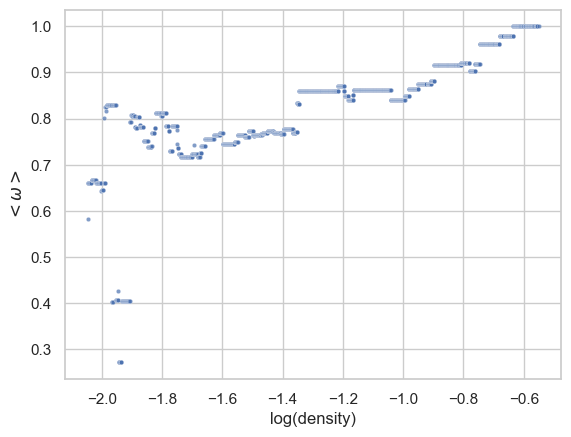

In [4]:
data = {
  "density" : np.log(C_ENSEMBLE2),
  "omega" : OMG_ENSEMBLE2
}

data = pd.DataFrame(data).groupby("density")["omega"].mean().reset_index()

# x_smooth = data["density"].rolling(window=20, win_type='gaussian', center=True).mean(std=0.3)
# y_smooth = data["omega"].rolling(window=20, win_type='gaussian', center=True).mean(std=0.3)

# spl = interpolate.UnivariateSpline(C_ENSEMBLE2[corder], OMG_ENSEMBLE2[corder])

fig, ax = plt.subplots(1, 1)

sns.scatterplot(
  data=data,
  x="density",
  y="omega",
  s=10, alpha=0.7,
  ax=ax
)

# sns.lineplot(
#   x=x_smooth, y=y_smooth,
#   color=sns.color_palette("deep")[1],
#   ax=ax
# )
plt.xlabel("log(density)")
plt.ylabel(r"$<\omega>$")
plt.show()

In [5]:
max_omega = data.loc[(data["density"] >= -2) & (data["density"] < -1.8)]["omega"].max()
min_density = np.exp(data["density"].loc[data["omega"] == max_omega].min())
print(min_density)

0.13751044277360067


In [8]:
den = density(NET.A)
kk = 0
while den > min_density:
  C = NET.CC * th_pass_graph(NET.A, edge_weights[kk])
  den = density(C)
  kk += 1

Amin = C / np.sum(C, axis=0)

print(kk-1)

1955


Compute link hierarchical agglomeration ----


/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/modules/hierarmerge.py:713: RuntimeWarning: divide by zero encountered in log
  src_inset[i, j] = -2 * np.log(ct.Hellinger2(self.A[i, :], self.A[j, :], i, j))
/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/modules/hierarmerge.py:716: RuntimeWarning: divide by zero encountered in log
  tgt_inset[i, j] = -2 * np.log(ct.Hellinger2(self.A[:, i], self.A[:, j], i, j))


source lambda:
 0.046593183984229694
target lambda:
 0.05055570530008076
source characteristic length: 5.851180260403588
target characteristic length: -2.3279094432161083
Mu-free
Compute node hierarchy ----
Commencer: la abre a merde
25%
50%
75%
Voila, bon ami
Print hierarchy newicks
((((((((((v1c:0,v2c:0):0.07917984703900582,(v4c:0,mtc:0):0.05649658337055885):0.11904556833554603,tepd:0):0.0,(v4lf:0,teo:0):0.0):0.017770266565217407,((((v1fplf:0,v2fplf:0):0.018900884167401766,v6:0):0.12154243413593646,((lip:0,mst:0):0.01609170240741742,(dp:0,mtp:0):0.016115663082190812):0.06651061592509477):0.02220030427370745,7a:0):0.05864202476440794):0.02914607623756249,(((((7b:0,2:0):0.0,((((1:0,f1:0):0.029581894876355652,((((((((24c:0,f7:0):0.0,f6:0):0.08012716327885172,(9:0,8b:0):0.0):0.018436754589789106,((((9/46d:0,8m:0):0.020774024492483778,46d:0):0.0016752779388112815,(((8l:0,8r:0):0.010063497898712637,45a:0):0.023830098372428554,12:0):0.011692210937794267):0.01101223775294935,9/46v:0):0.02270

/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/plotting_modules/plotting_N.py:365: RuntimeWarning: divide by zero encountered in log
  daki = -2 * np.log(self.aki.copy())
/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/plotting_modules/plotting_N.py:375: RuntimeWarning: divide by zero encountered in log
  daik = -2 * np.log(self.aik.copy())


Plot neuron-distance freq!!!

loc:	 1.267415
lambda:	 0.11990747615800167
llhood -47758918.96879341
error 2.35438540206602
No histogram
Find node partition using _S
Best K: 82
Best R: 22	 Score: _S
No heatmap structure


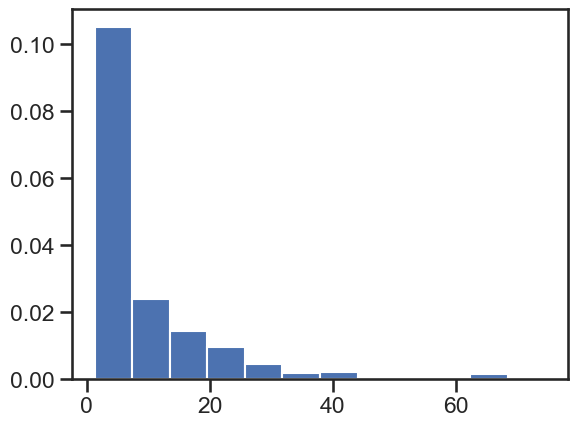

In [9]:
PRUNE_NET = MAC57(
  linkage, mode,
  nlog10 = nlog10,
  structure = structure,
  lookup = lookup,
  version = version,
  nature = nature,
  model = imputation_method,
  distance = distance,
  inj = __inj__,
  topology = topology,
  index = index,
  mapping = mapping,
  cut = cut,
  b = bias
)

PRUNE_NET.A = Amin
PRUNE_NET.CC = NET.CC * th_pass_graph(NET.A, edge_weights[kk-1])

H = Hierarchy(
  PRUNE_NET, Amin, Amin, PRUNE_NET.D,
  __nodes__, linkage, mode, lookup=lookup,
  index=index
)
## Compute features ----
H.BH_features_cpp_no_mu()
## Compute lq arbre de merde ----
H.la_abre_a_merde_cpp(H.BH[0])
# Set labels to network ----
L = colregion(PRUNE_NET, labels_name=f"labels{__inj__}")
H.set_colregion(L)
H.delete_dist_matrix()

plot_h = Plot_H(PRUNE_NET, H)
plot_n = Plot_N(PRUNE_NET, H)
HS = Hierarchical_Entropy(H.Z, H.nodes, PRUNE_NET.struct_labels[:PRUNE_NET.nodes])
HS.Z2dict("short")

HS.zdict2newick(HS.tree, weighted=T, on=T)
plot_h.plot_newick_R(HS.newick, HS.total_nodes, root_position=1-H.Z[:, 2][-1], weighted=T, on=F)

RN = PRUNE_NET.A[:__nodes__, :].copy()
RN[RN > 0] = -np.log(RN[RN > 0])
np.fill_diagonal(RN, 0.)

RW = PRUNE_NET.A.copy()
RW[RW > 0] = -np.log(RW[RW > 0])
np.fill_diagonal(RW, 0.)

RW10 = PRUNE_NET.A.copy()
RW10[RW10 > 0] = -np.log10(RW10[RW10 > 0])
np.fill_diagonal(RW10, 0.)


print("Network density:")
print(density(PRUNE_NET.CC))

plot_n.plot_akis(PRUNE_NET.D, s=5, suffix="_prune", on=T)
plot_n.projection_probability(PRUNE_NET.CC, "EXPMLE", suffix="_prune", bins=12, on=T)
plot_n.histogram_weight(-RW10, label=r"$\log10(p(i,j))$", suffix="log10_p_prune", on=F)

for SCORE in opt_score:
  # Get best K and R ----
  K, R, TH = get_best_kr_equivalence(SCORE, H)

  for k, r, th in zip(K, R, TH):
    print(f"Find node partition using {SCORE}")
    print("Best K: {}\nBest R: {}\t Score: {}".format(k, r, SCORE))
    H.set_kr(k, r, score=SCORE)
    rlabels = get_labels_from_Z(H.Z, r)
    rlabels = skim_partition(rlabels)
    # Plot H ----
    plot_h.heatmap_dendro(
      r, -RN, on=F, score="FLNe",
      cbar_label=r"$\log_{10}$FLNe", font_size = 12, suffix="_prune"
    )

    PRUNE_NET.overlap, PRUNE_NET.data_nocs, noc_sizes, rlabels2  = discovery_channel[discovery](
      H, k, rlabels, direction="both", index=index
    )

    plot_n.plot_network_covers(
      k, RN, rlabels2, rlabels,
      PRUNE_NET.data_nocs,
      noc_sizes, H.colregion.labels[:H.nodes], ang=0,
      score=SCORE, direction="both", spring=F, font_size=16,
      scale=0.45,
      suffix="small_prune", cmap_name="hls", not_labels=F, on=F#, figsize=(8,8)
    )